In [62]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cuda


In [63]:
class GridEnvironment:
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows = rows
        self.cols = cols
        self.start_state = (0, 0)
        self.goal_state = (rows - 1, cols - 1)
        self.state = self.start_state

        self.state_dim = 2
        self.action_dim = 4

        # Actions: 0=up, 1=down, 2=left, 3=right
        self.action_map = {
            0: (-1, 0),
            1: (1, 0),
            2: (0, -1),
            3: (0, 1)
        }

    def reset(self) -> torch.Tensor:
        # Reset to start position
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        # Normalize coordinates to [0, 1]
        norm_row = state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        norm_col = state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        return torch.tensor([norm_row, norm_col], dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        # Move agent based on action
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True

        dr, dc = self.action_map[action]
        r, c = self.state
        nr, nc = r + dr, c + dc

        reward = -0.1  # default step penalty

        # Check if move is valid
        if not (0 <= nr < self.rows and 0 <= nc < self.cols):
            nr, nc = r, c
            reward = -1.0  # penalty for hitting wall

        self.state = (nr, nc)
        done = self.state == self.goal_state
        if done:
            reward = 10.0  # reward for reaching goal

        return self._get_state_tensor(self.state), reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

    def get_state_dimension(self) -> int:
        return self.state_dim


In [64]:
# Define the Actor network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        logits = self.fc(x)
        return F.softmax(logits, dim=-1)

In [65]:
# Define the Critic network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [66]:
# Create environment and instantiate the networks on GPU (if available)
env = GridEnvironment(rows=10, cols=10)
state_dim = env.get_state_dimension()
action_dim = env.get_action_space_size()

actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [67]:
# PPO hyperparameters
gamma = 0.99
clip_epsilon = 0.2
ppo_epochs = 4

In [68]:
# Simple rollout memory for storing trajectories
class RolloutBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []

    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []

buffer = RolloutBuffer()

In [73]:
# PPO training loop with CUDA support and benchmarking
def ppo_train(num_episodes):
    actor.train()
    critic.train()

    start_time = time.time()
    all_episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        buffer.clear()

        while not done:
            # Use no_grad for inference to save memory/computation
            with torch.no_grad():
                action_probs = actor(state)
            dist = Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, done = env.step(action.item())

            buffer.states.append(state)
            buffer.actions.append(action)
            buffer.log_probs.append(log_prob)
            buffer.rewards.append(reward)
            buffer.dones.append(done)

            state = next_state
            episode_reward += reward

        all_episode_rewards.append(episode_reward)

        # Compute discounted returns
        returns = []
        discounted_sum = 0
        for reward, is_done in zip(reversed(buffer.rewards), reversed(buffer.dones)):
            if is_done:
                discounted_sum = 0
            discounted_sum = reward + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        states_tensor = torch.stack(buffer.states)
        actions_tensor = torch.stack(buffer.actions)
        old_log_probs_tensor = torch.stack(buffer.log_probs)

        # PPO update (multiple epochs over the collected trajectory)
        for _ in range(ppo_epochs):
            action_probs = actor(states_tensor)
            dist = Categorical(action_probs)
            new_log_probs = dist.log_prob(actions_tensor)
            entropy = dist.entropy().mean()

            state_values = critic(states_tensor).squeeze()
            advantages = returns - state_values.detach()

            # Compute the probability ratio
            ratios = torch.exp(new_log_probs - old_log_probs_tensor)

            # Surrogate loss with clipping
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            actor_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy

            critic_loss = F.mse_loss(state_values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Reward: {episode_reward:.2f}")

    total_time = time.time() - start_time
    print(f"Total Training Time (CUDA version): {total_time:.2f} seconds")
    return all_episode_rewards

In [74]:
def ppo_train_cpu(num_episodes):
    cpu_device = torch.device("cpu")
    env_cpu = GridEnvironment(rows=10, cols=10)
    actor_cpu = Actor(state_dim, action_dim).to(cpu_device)
    critic_cpu = Critic(state_dim).to(cpu_device)
    actor_optimizer_cpu = optim.Adam(actor_cpu.parameters(), lr=1e-3)
    critic_optimizer_cpu = optim.Adam(critic_cpu.parameters(), lr=1e-3)

    buffer_cpu = RolloutBuffer()
    episode_rewards = []

    start_time = time.time()
    for episode in range(num_episodes):
        state = env_cpu.reset().to(cpu_device)
        done = False
        buffer_cpu.clear()
        total_reward = 0

        while not done:
            with torch.no_grad():
                action_probs = actor_cpu(state)
            dist = Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            next_state, reward, done = env_cpu.step(action.item())

            buffer_cpu.states.append(state)
            buffer_cpu.actions.append(action)
            buffer_cpu.log_probs.append(log_prob)
            buffer_cpu.rewards.append(reward)
            buffer_cpu.dones.append(done)

            state = next_state.to(cpu_device)
            total_reward += reward

        episode_rewards.append(total_reward)

        # Compute discounted returns
        returns = []
        discounted_sum = 0
        for reward, is_done in zip(reversed(buffer_cpu.rewards), reversed(buffer_cpu.dones)):
            if is_done:
                discounted_sum = 0
            discounted_sum = reward + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.tensor(returns, dtype=torch.float32, device=cpu_device)
        states_tensor = torch.stack(buffer_cpu.states).to(cpu_device)
        actions_tensor = torch.stack(buffer_cpu.actions).to(cpu_device)
        old_log_probs_tensor = torch.stack(buffer_cpu.log_probs).to(cpu_device)

        for _ in range(ppo_epochs):
            action_probs = actor_cpu(states_tensor)
            dist = Categorical(action_probs)
            new_log_probs = dist.log_prob(actions_tensor)
            entropy = dist.entropy().mean()

            state_values = critic_cpu(states_tensor).squeeze()
            advantages = returns - state_values.detach()

            ratios = torch.exp(new_log_probs - old_log_probs_tensor)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            actor_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy

            critic_loss = F.mse_loss(state_values, returns)

            actor_optimizer_cpu.zero_grad()
            actor_loss.backward()
            actor_optimizer_cpu.step()

            critic_optimizer_cpu.zero_grad()
            critic_loss.backward()
            critic_optimizer_cpu.step()

        if episode % 10 == 0 or episode == num_episodes - 1:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {total_reward:.2f}")

    total_time = time.time() - start_time
    print(f"Total Training Time (CPU version): {total_time:.2f} seconds")

    return episode_rewards


Training PPO (CUDA-enhanced version):
Episode 10/150, Reward: 6.30
Episode 20/150, Reward: 8.30
Episode 30/150, Reward: 8.30
Episode 40/150, Reward: 7.30
Episode 50/150, Reward: 6.30
Episode 60/150, Reward: 8.30
Episode 70/150, Reward: 7.30
Episode 80/150, Reward: 8.30
Episode 90/150, Reward: 5.30
Episode 100/150, Reward: 8.30
Episode 110/150, Reward: 8.30
Episode 120/150, Reward: 8.30
Episode 130/150, Reward: 6.30
Episode 140/150, Reward: 8.30
Episode 150/150, Reward: 6.10
Total Training Time (CUDA version): 4.61 seconds

Benchmarking previous CPU implementation:
Episode 1/150, Reward: -74.30
Episode 11/150, Reward: -13.50
Episode 21/150, Reward: 2.90
Episode 31/150, Reward: 5.50
Episode 41/150, Reward: 1.50
Episode 51/150, Reward: 1.70
Episode 61/150, Reward: 5.70
Episode 71/150, Reward: 3.50
Episode 81/150, Reward: 8.30
Episode 91/150, Reward: 2.30
Episode 101/150, Reward: 6.90
Episode 111/150, Reward: 7.30
Episode 121/150, Reward: 8.10
Episode 131/150, Reward: 7.30
Episode 141/150,

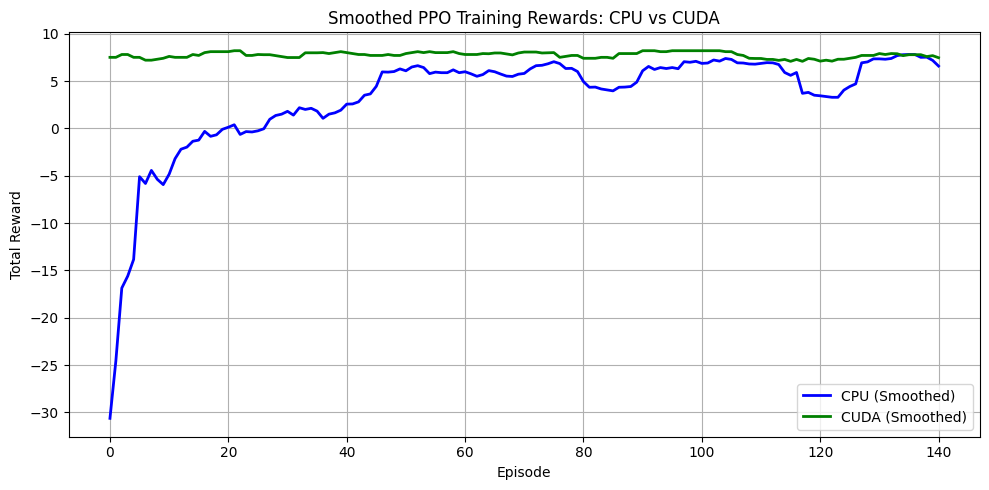

In [77]:
print("Training PPO (CUDA-enhanced version):")
episode_rewards_cuda = ppo_train(num_episodes=150)

print("\nBenchmarking previous CPU implementation:")
episode_rewards_cpu = ppo_train_cpu(num_episodes=150)

def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_cpu = smooth(episode_rewards_cpu)
smoothed_cuda = smooth(episode_rewards_cuda)

plt.figure(figsize=(10, 5))
plt.plot(smoothed_cpu, label="CPU (Smoothed)", color='blue', linewidth=2)
plt.plot(smoothed_cuda, label="CUDA (Smoothed)", color='green', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Smoothed PPO Training Rewards: CPU vs CUDA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

